In [21]:
!pip install yfinance

In [35]:
import yfinance as yf
import pandas as pd

tickers = ["AAPL", "MSFT", "GOOGL"]
start_date = "2022-01-01"
end_date = "2024-12-31"

In [36]:
data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  3 of 3 completed


In [37]:
print(data.columns)

MultiIndex([( 'Close',  'AAPL'),
            ( 'Close', 'GOOGL'),
            ( 'Close',  'MSFT'),
            (  'High',  'AAPL'),
            (  'High', 'GOOGL'),
            (  'High',  'MSFT'),
            (   'Low',  'AAPL'),
            (   'Low', 'GOOGL'),
            (   'Low',  'MSFT'),
            (  'Open',  'AAPL'),
            (  'Open', 'GOOGL'),
            (  'Open',  'MSFT'),
            ('Volume',  'AAPL'),
            ('Volume', 'GOOGL'),
            ('Volume',  'MSFT')],
           names=['Price', 'Ticker'])


In [38]:
print(data.head())

Price            Close                                High              \
Ticker            AAPL       GOOGL        MSFT        AAPL       GOOGL   
Date                                                                     
2022-01-03  178.645645  144.301605  325.634796  179.499574  145.157013   
2022-01-04  176.378342  143.712418  320.051086  179.558457  145.787989   
2022-01-05  171.686737  137.119446  307.765015  176.839695  143.811952   
2022-01-06  168.820694  137.092072  305.333099  172.059699  139.274144   
2022-01-07  168.987518  136.365051  305.488708  170.921105  137.789743   

Price                          Low                                Open  \
Ticker            MSFT        AAPL       GOOGL        MSFT        AAPL   
Date                                                                     
2022-01-03  328.796299  174.425140  143.029185  320.800127  174.542917   
2022-01-04  326.072535  175.809061  143.032669  317.239767  179.254190   
2022-01-05  317.191159  171.411914  1

In [39]:
import numpy as np

In [48]:
# Select only the Close prices
close_prices = data['Close']

# Calculate daily returns
returns = close_prices.pct_change().dropna()

# Now you can do statistics on returns
mean_returns = returns.mean()
volatility = returns.std()
correlation = returns.corr()

print("Mean Returns:\n", mean_returns)
print("Volatility:\n", volatility)
print("Correlation matrix:\n", correlation)


Mean Returns:
 Ticker
AAPL     0.000601
GOOGL    0.000586
MSFT     0.000502
dtype: float64
Volatility:
 Ticker
AAPL     0.017076
GOOGL    0.020637
MSFT     0.017381
dtype: float64
Correlation matrix:
 Ticker      AAPL     GOOGL      MSFT
Ticker                              
AAPL    1.000000  0.622300  0.684721
GOOGL   0.622300  1.000000  0.694132
MSFT    0.684721  0.694132  1.000000


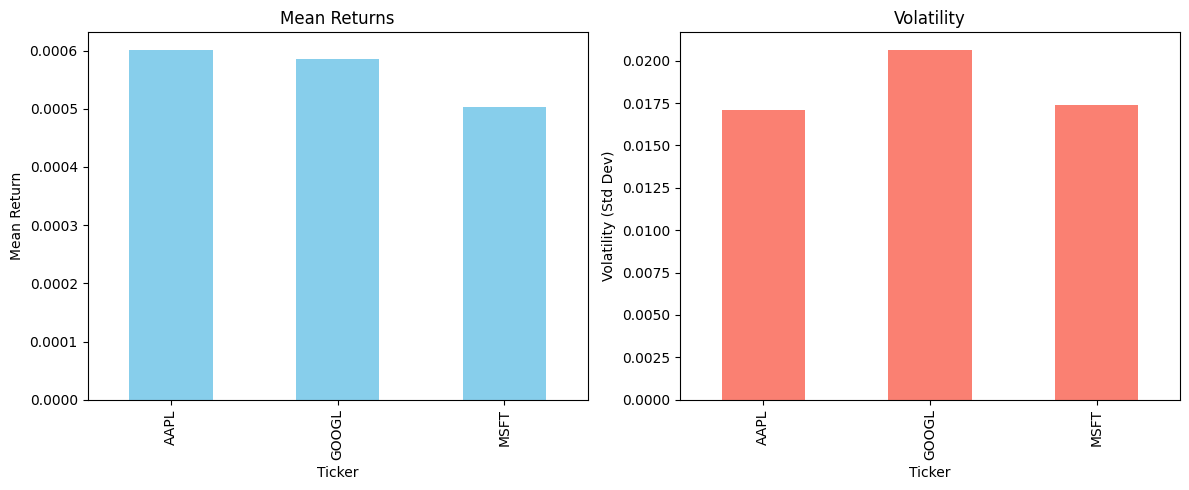

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar chart for Mean Returns and Volatility
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

mean_returns.plot(kind='bar', ax=ax[0], color='skyblue', title='Mean Returns')
ax[0].set_ylabel('Mean Return')

volatility.plot(kind='bar', ax=ax[1], color='salmon', title='Volatility')
ax[1].set_ylabel('Volatility (Std Dev)')

plt.tight_layout()
plt.show()


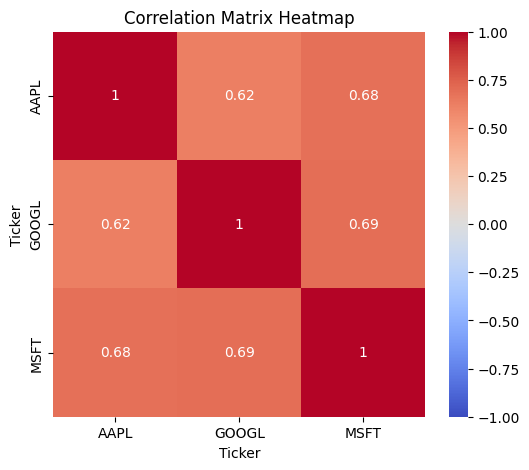

In [56]:
# 2. Heatmap for Correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()



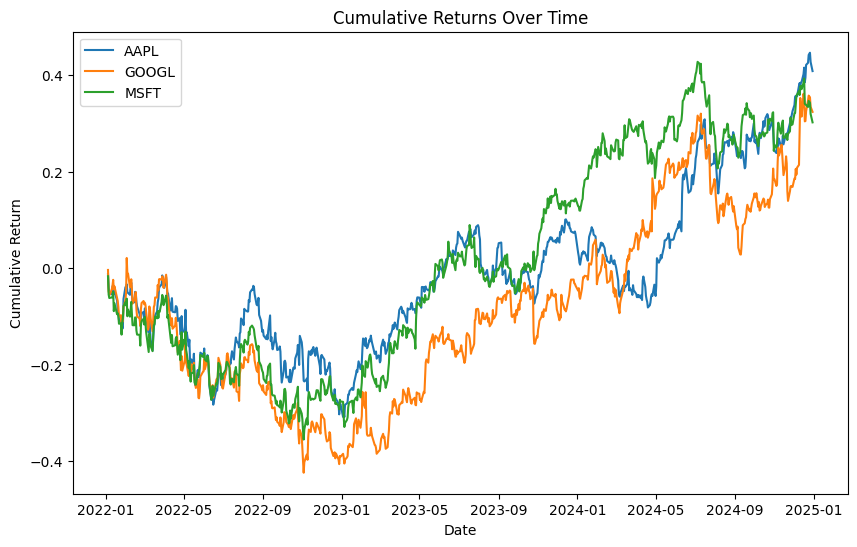

In [57]:
# 3. Line plot for cumulative returns over time
cumulative_returns = (returns + 1).cumprod() - 1

plt.figure(figsize=(10, 6))
for ticker in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)

plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

In [51]:
import numpy as np
import cvxpy as cp

# Use returns dataframe calculated before
# Changed price_data to data to use the correct DataFrame
returns = data['Close'].pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()

n = len(mean_returns)
weights = cp.Variable(n)
ret = mean_returns.values @ weights
risk = cp.quad_form(weights, cov_matrix.values)

# Maximize return - risk penalty
gamma = 0.1  # risk aversion parameter
prob = cp.Problem(cp.Maximize(ret - gamma * risk),
                  [cp.sum(weights) == 1,
                   weights >= 0])

prob.solve()
opt_weights = weights.value

print("Optimal portfolio weights:")
for i, ticker in enumerate(mean_returns.index):
    print(f"{ticker}: {opt_weights[i]:.4f}")

Optimal portfolio weights:
AAPL: 1.0000
GOOGL: 0.0000
MSFT: 0.0000


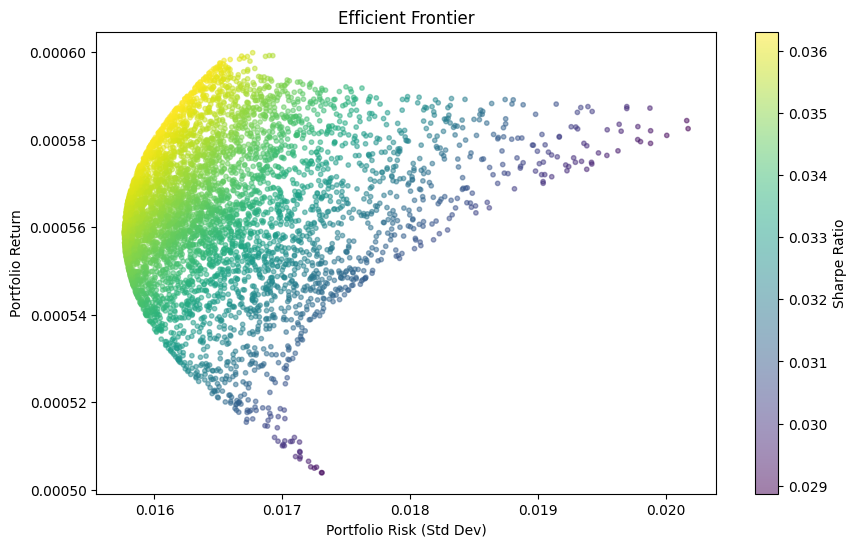

In [58]:
num_portfolios = 5000

results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)
    weights_record.append(weights)

    # Portfolio return and risk
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Store results
    results[0,i] = portfolio_std
    results[1,i] = portfolio_return
    results[2,i] = results[1,i] / results[0,i]  # Sharpe ratio (assuming risk-free = 0)

# Plot Efficient Frontier
plt.figure(figsize=(10,6))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis', marker='o', s=10, alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Portfolio Risk (Std Dev)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier')
plt.show()


In [59]:
risk_free_rate = 0.01 / 252  # daily risk free rate approx

sharpe_ratios = (mean_returns - risk_free_rate) / returns.std()
print("Sharpe Ratios:\n", sharpe_ratios)

Sharpe Ratios:
 Ticker
AAPL     0.032889
GOOGL    0.026486
MSFT     0.026618
dtype: float64


In [60]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Assuming you already have:
# mean_returns (Series), cov_matrix (DataFrame), risk_free_rate (float), returns (DataFrame)

# Generate random portfolios for frontier
num_portfolios = 5000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)
    weights_record.append(weights)

    ret = np.sum(mean_returns * weights)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (ret - risk_free_rate) / vol

    results[0,i] = vol
    results[1,i] = ret
    results[2,i] = sharpe

# Locate max Sharpe ratio portfolio
max_sharpe_idx = np.argmax(results[2])
max_sharpe_vol = results[0, max_sharpe_idx]
max_sharpe_ret = results[1, max_sharpe_idx]

# Plotly figure
fig = go.Figure()

# Efficient frontier scatter
fig.add_trace(go.Scatter(
    x=results[0],
    y=results[1],
    mode='markers',
    marker=dict(color=results[2], colorscale='Viridis', showscale=True, colorbar=dict(title='Sharpe Ratio')),
    name='Random Portfolios'
))

# Max Sharpe portfolio
fig.add_trace(go.Scatter(
    x=[max_sharpe_vol],
    y=[max_sharpe_ret],
    mode='markers',
    marker=dict(color='red', size=15, symbol='star'),
    name='Max Sharpe Ratio'
))

# Individual assets
for ticker in mean_returns.index:
    ret = mean_returns[ticker]
    vol = returns[ticker].std()
    sharpe = (ret - risk_free_rate) / vol
    fig.add_trace(go.Scatter(
        x=[vol],
        y=[ret],
        mode='markers+text',
        marker=dict(size=12, symbol='circle'),
        text=[ticker],
        textposition='top center',
        name=f'{ticker} (Sharpe: {sharpe:.3f})'
    ))

fig.update_layout(
    title='Efficient Frontier with Maximum Sharpe Ratio and Individual Assets',
    xaxis_title='Volatility (Risk)',
    yaxis_title='Expected Return',
    template='plotly_white',
    legend=dict(x=0.8, y=0.1)
)

fig.show()

In [61]:
confidence_level = 0.05
VaR = returns.quantile(confidence_level)
print(f"Value at Risk (5% level):\n{VaR}")

Value at Risk (5% level):
Ticker
AAPL    -0.027196
GOOGL   -0.031642
MSFT    -0.027486
Name: 0.05, dtype: float64


In [75]:
import plotly.express as px

fig = px.bar(
    x=VaR.index,
    y=VaR.values,
    labels={"x": "Ticker", "y": "Value at Risk (5%)"},
    title="Value at Risk (5% level) by Ticker",
    color=VaR.values,
    color_continuous_scale="Sunset",
)

fig.update_layout(yaxis=dict(autorange="reversed"))  # Since VaR is negative, reverse y-axis for better view
fig.show()


In [78]:
# Example: Daily price range PER TICKER
# Iterate through each ticker and calculate the price range
for ticker in tickers:
    # Create a new column with a MultiIndex key ('Price Range', ticker)
    # and assign the difference between 'High' and 'Low' for that specific ticker.
    data[('Price Range', ticker)] = data[('High', ticker)] - data[('Low', ticker)]

# Example: 20-day rolling average volume PER TICKER
# Iterate through each ticker and calculate the rolling average volume
for ticker in tickers:
    # Create a new column with a MultiIndex key ('Volume MA', ticker)
    # and assign the rolling mean of 'Volume' for that specific ticker.
    data[('Volume MA', ticker)] = data[('Volume', ticker)].rolling(window=20).mean()

# Now data DataFrame should have 'Price Range' and 'Volume MA' top-level columns,
# each with the ticker sub-columns.

# You can optionally print the columns again to verify the new structure
print(data.columns)
print(data.head())

MultiIndex([(      'Close',  'AAPL'),
            (      'Close', 'GOOGL'),
            (      'Close',  'MSFT'),
            (       'High',  'AAPL'),
            (       'High', 'GOOGL'),
            (       'High',  'MSFT'),
            (        'Low',  'AAPL'),
            (        'Low', 'GOOGL'),
            (        'Low',  'MSFT'),
            (       'Open',  'AAPL'),
            (       'Open', 'GOOGL'),
            (       'Open',  'MSFT'),
            (     'Volume',  'AAPL'),
            (     'Volume', 'GOOGL'),
            (     'Volume',  'MSFT'),
            ('Price Range',  'AAPL'),
            ('Price Range',  'MSFT'),
            (  'Volume MA',  'AAPL'),
            (  'Volume MA',  'MSFT')],
           names=['Price', 'Ticker'])
Price            Close                                High              \
Ticker            AAPL       GOOGL        MSFT        AAPL       GOOGL   
Date                                                                     
2022-01-03  178.6

In [79]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px # Import plotly.express

# Example: Daily price range PER TICKER
# Iterate through each ticker and calculate the price range
for ticker in tickers:
    # Create a new column with a MultiIndex key ('Price Range', ticker)
    # and assign the difference between 'High' and 'Low' for that specific ticker.
    data[('Price Range', ticker)] = data[('High', ticker)] - data[('Low', ticker)]

# Example: 20-day rolling average volume PER TICKER
# Iterate through each ticker and calculate the rolling average volume
for ticker in tickers:
    # Create a new column with a MultiIndex key ('Volume MA', ticker)
    # and assign the rolling mean of 'Volume' for that specific ticker.
    data[('Volume MA', ticker)] = data[('Volume', ticker)].rolling(window=20).mean()

# Now data DataFrame should have 'Price Range' and 'Volume MA' top-level columns,
# each with the ticker sub-columns.

# You can optionally print the columns again to verify the new structure
# print(data.columns)
# print(data.head())

# %%
# Add visualizations for the new columns

# Plotting Price Range over time for each ticker
fig_pr = go.Figure()
for ticker in tickers:
    fig_pr.add_trace(go.Scatter(x=data.index, y=data[('Price Range', ticker)], mode='lines', name=ticker))

fig_pr.update_layout(
    title='Daily Price Range Over Time',
    xaxis_title='Date',
    yaxis_title='Price Range ($)',
    template='plotly_white',
    legend=dict(x=0.01, y=0.99)
)
fig_pr.show()

# Plotting Volume Moving Average over time for each ticker
fig_vol_ma = go.Figure()
for ticker in tickers:
    fig_vol_ma.add_trace(go.Scatter(x=data.index, y=data[('Volume MA', ticker)], mode='lines', name=ticker))

fig_vol_ma.update_layout(
    title='20-Day Rolling Average Volume Over Time',
    xaxis_title='Date',
    yaxis_title='Volume (Shares)',
    template='plotly_white',
    legend=dict(x=0.01, y=0.99)
)
fig_vol_ma.show()

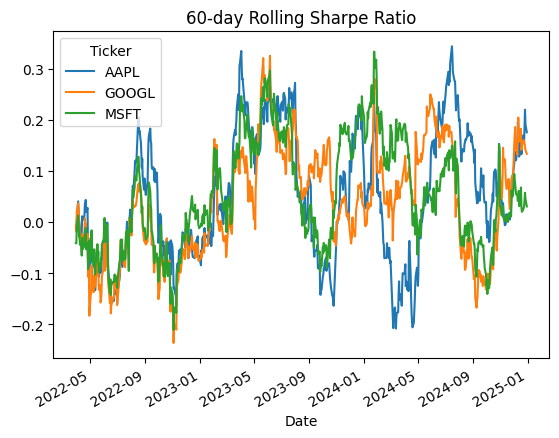

In [81]:
rolling_sharpe = (returns.rolling(60).mean() - risk_free_rate) / returns.rolling(60).std()
rolling_sharpe.plot(title="60-day Rolling Sharpe Ratio")
plt.show()

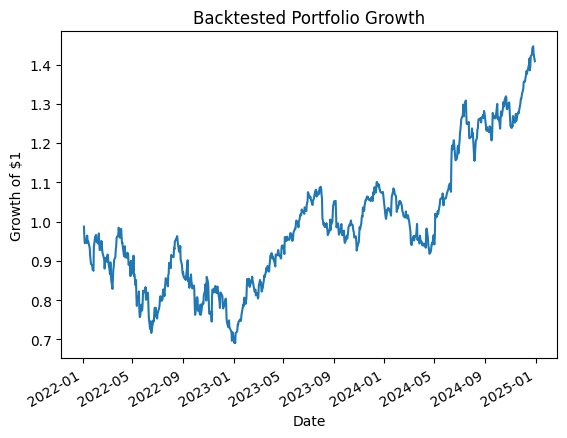

In [82]:
portfolio_returns = (returns * opt_weights).sum(axis=1)
cumulative_returns = (1 + portfolio_returns).cumprod()

cumulative_returns.plot(title="Backtested Portfolio Growth")
plt.ylabel("Growth of $1")
plt.show()


In [83]:
summary = pd.DataFrame({
    'Mean Return': mean_returns,
    'Volatility': returns.std(),
    'Sharpe Ratio': sharpe_ratios,
    'VaR (5%)': VaR
})
print(summary)


        Mean Return  Volatility  Sharpe Ratio  VaR (5%)
Ticker                                                 
AAPL       0.000601    0.017076      0.032889 -0.027196
GOOGL      0.000586    0.020637      0.026486 -0.031642
MSFT       0.000502    0.017381      0.026618 -0.027486
